In [1]:
import warnings as _wrn
_wrn.filterwarnings('always')

In [2]:
import sys as _sys
import itertools as _itr

import numpy as _nmp
import numpy.random as _rnd
import matplotlib.pyplot as _plt
import pandas as _pnd

%load_ext autoreload
%autoreload 2
%matplotlib inline

_plt.style.use('ggplot')

In [6]:
import eQTLseq as _assoc

In [7]:
# ... load real data

data = {
    'G': _pnd.read_table('/home/dimitris/Data/Geuvadis/VCF/genotypes.TF.common.HIGH.txt', index_col=0, header=None),
    'Z': _pnd.read_table('/home/dimitris/Data/Geuvadis/counts/counts_miRNAs.txt', index_col=0)
    # COUNTS = (_pnd.read_table('/home/dimitris/Data/Geuvadis/counts/counts_genes.txt', index_col=[0,1,2])
    #           .xs('protein_coding', level='BIOTYPE', drop_level=False))    
}

samples = data['G'].index & data['Z'].columns

data['Z'] = data['Z'][samples].values
data['G'] = data['G'].loc[samples].values

(452, 21) (2226, 452)


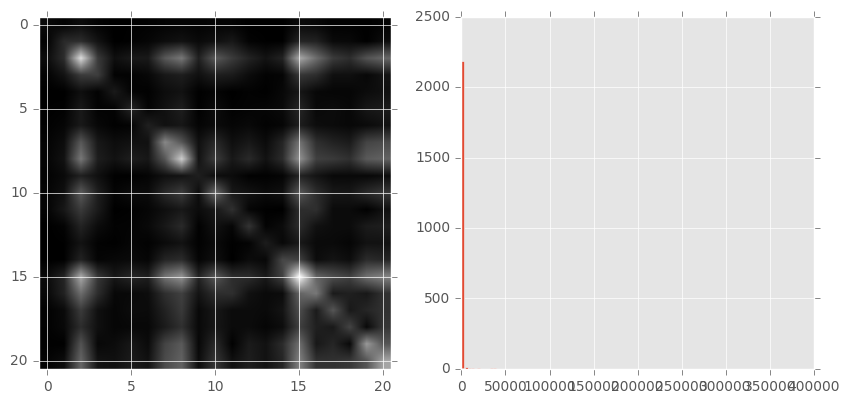

In [45]:
# prepare data

Z = data['Z']
G = data['G']

Z = Z[Z.sum(1) > 0, :]       # keep only expressed tags
# Z = Z[Z.sum(1) > _nmp.percentile(Z.sum(1), 60), :]
G = G[:, _nmp.std(G, 0) > 0] # keep only non-monomorphic loci

Z = Z / _assoc.calculate_norm_factors(Z)
# Z = _assoc.transform_data(Z, kind='vst')

print(G.shape, Z.shape)

# take a quick look at the data

_plt.figure(figsize=(10,10));
_plt.subplot(2,2,1); _plt.imshow(G.T.dot(G), cmap=_plt.cm.Greys_r);
_plt.subplot(2,2,2); _plt.hist(Z[:, 0], bins=100);

In [71]:
_rnd.seed(0)
res = _assoc.run(Z.T, G, n_iters = 4000, model='NBinomial', scale=True, n_threads=4)

/home/dimitris/VENVS/py35mkl/lib/python3.5/site-packages/tqdm/_tqdm.py:65: DeprecationWarning: sys.getcheckinterval() and sys.setcheckinterval() are deprecated.  Use sys.setswitchinterval() instead.
  sys.setcheckinterval(100)
100%|██████████| 4000/4000 [21:23<00:00,  3.71it/s]


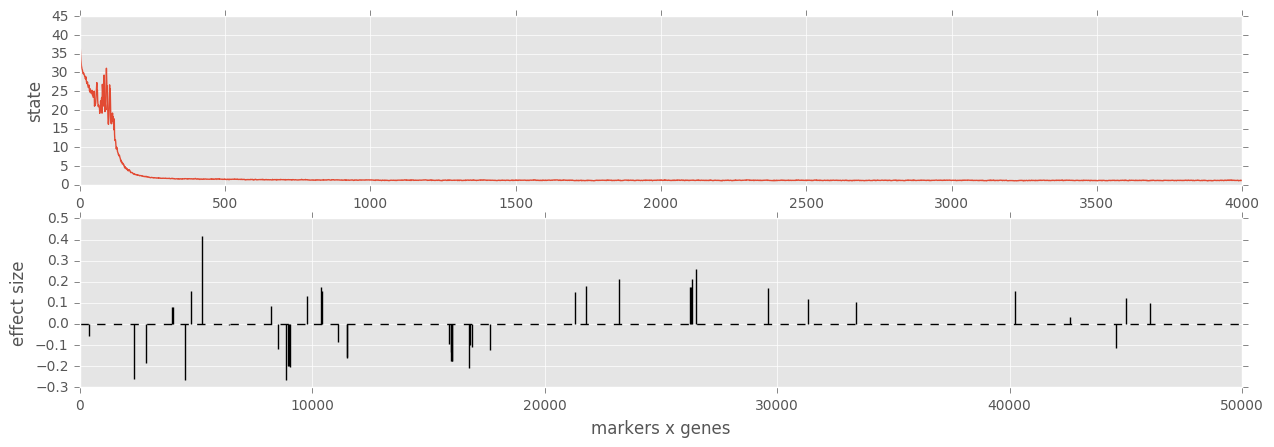

In [72]:
_plt.figure(figsize = (15,10));

_plt.subplot(4,1,1); _plt.plot(res['state']); _plt.xlabel('iteration'); _plt.ylabel('state')

_plt.subplot(4,1,2); _plt.vlines(range(res['beta'].size), 0, res['beta'].ravel()); _plt.xlabel('markers x genes'); _plt.ylabel('effect size')
_plt.axhline(linestyle='--', color='k');

In [73]:
_nmp.transpose((_nmp.abs(res['beta']) > 1e-6).nonzero()).shape

(45, 2)

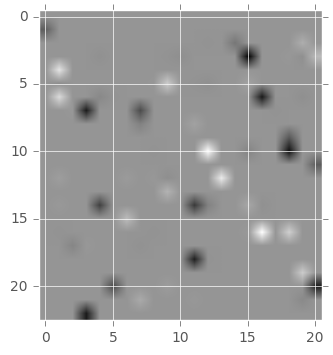

In [77]:
_plt.imshow(res['beta'][::100, :], cmap=_plt.cm.gray)

In [74]:
res_nbin = res

In [62]:
import pickle as _pkl

In [78]:
files = {
    'Normal.log': res_log ,
    'Normal.boxcox': res_bcox,
    'Normal.blom': res_blom,
    'Normal.voom': res_voom,
    'Normal.vst': res_vst,
    'Binomial.none': res_bin,
    'NBinomial.none': res_nbin,
    'Poisson.none': res_pois
}

for key in files:
    f = 'TF.common.HIGH.miRNAs.452.{}'.format(key)
    out = files[key]
    with open('/home/dimitris/WTCHG/Projects/eQTLseq/results/geuvadis/ROC/{}.pkl'.format(f), 'wb') as fh:
        _pkl.dump(out, fh)

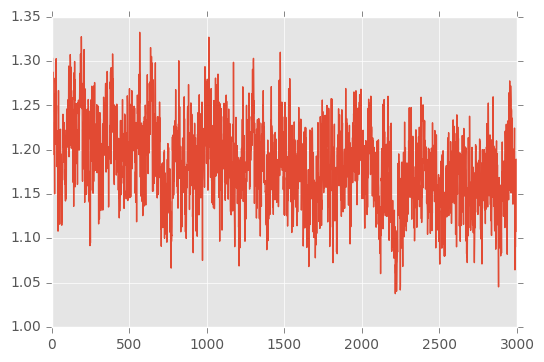

In [75]:
_plt.plot(res_nbin['state'][1000:])

In [54]:
pwd

'/home/dimitris/Projects/eqtlseq'